# 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다. 평가문항 상세기준

1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다. 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.

2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다. 적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.

3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다. 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

# Step 1. 데이터의 전처리

* sessionid = user id 
* rating - 낮은 평가 어떻게 할지 고민
* time - 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

In [2]:
# 데이터 불러오기
data_path = Path(os.getenv('HOME')+'/aiffel/aiffel_exp_data/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다. 

In [4]:
# 평점이 3점 이상인것만 남긴다.
data= data[data['Rating']>=3]
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [5]:
# 유저 id: 영화 평점 쓴 사람, item id:영화 제목

data['UserId'].nunique(), data['ItemId'].nunique()

(6039, 3628)

In [6]:
# 영화 갯수 1번이 53개의 영화를 봄
UserId_length = data.groupby('UserId').size()
UserId_length

UserId
1        53
2       116
3        46
4        19
5       143
       ... 
6036    708
6037    189
6038     18
6039    119
6040    276
Length: 6039, dtype: int64

In [7]:
# 평점이 3점 이상인 사람은 한명당 평균 138번의 영화를 봤다. 
UserId_length.median(), UserId_length.mean() 

(81.0, 138.51266766020865)

In [8]:
UserId_length.min(), UserId_length.max()

(1, 1968)

In [9]:
#99.9% 세션은 길이가 1118. 길이가 1968인 세션이 있다. 
UserId_length.quantile(0.999)

1118.8860000000013

In [10]:
# 긴 세션 확인 
long_session = UserId_length[UserId_length==1968].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697055,4169,3207,3,1024172606
695958,4169,3413,3,1024173191
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760


In [70]:
#대부분의 세션 길이를 시각화 
length_count = UserId_length.groupby(UserId_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.99]

length_percent_cumsum_999

1      0.000166
7      0.000331
9      0.000994
10     0.001159
11     0.001987
         ...   
725    0.989237
726    0.989402
728    0.989568
731    0.989733
734    0.989899
Length: 584, dtype: float64

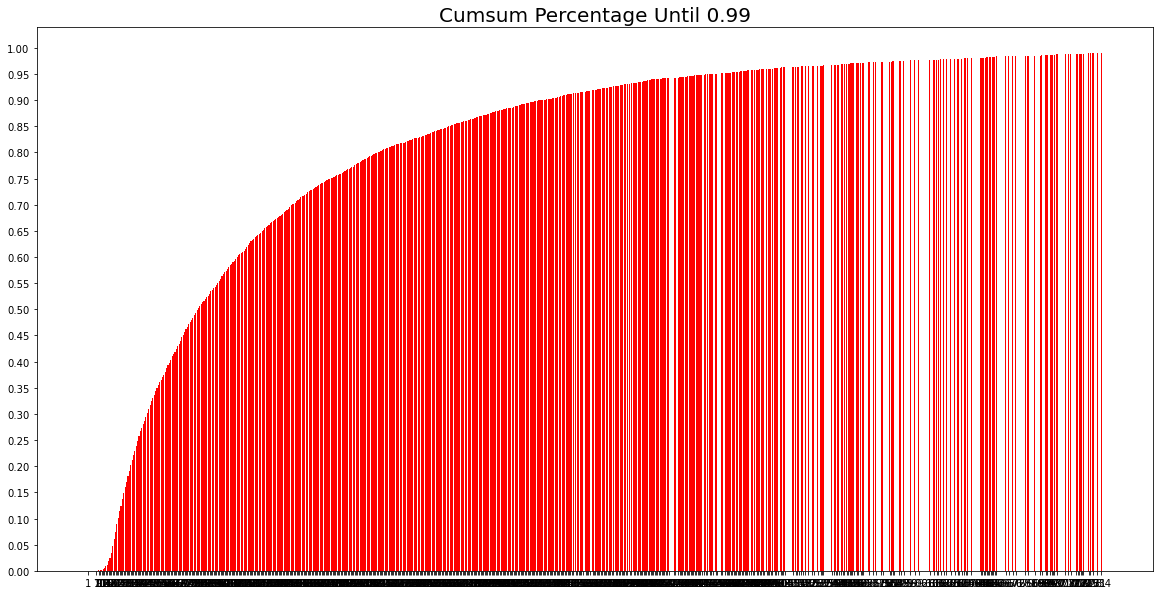

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.99', size=20)
plt.show()

# Session Time

In [73]:
# 데이터가 발생한 시간
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

1015352875
1046454590


In [74]:
type(latest) #가장 최근 데이터 

numpy.int64

In [75]:
month_ago = latest - 12*30*3600*24     # 최근 1년 데이터를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data #이 데이터는 lastest 부터 1년까지의 데이터

,UserId,ItemId,Rating,Time
5170,36,1387,5,1015904819
5267,36,1201,4,1015904819
5122,36,1291,5,1015904836
5123,36,2167,5,1015904905
5290,36,2951,4,1015904905
...,...,...,...,...
992358,5996,3835,3,1020113184
992279,5996,2422,3,1020113225
992702,5996,168,3,1031058746
992459,5996,339,4,1033997079


# Train/ Valid/ Test split

In [77]:
test_path = data_path / 'ratings.dat'
test= load_data(test_path)
test['Time'].min(), test['Time'].max()

(956703932, 1046454590)

In [76]:
def split_by_date(data: pd.DataFrame, monts: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < (final_time - monts*30*3600*24)].index
    session_in_test = session_last_time[session_last_time >= (final_time - monts*30*3600*24)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [78]:
tr, test = split_by_date(data, monts=1)
tr, val = split_by_date(tr, monts=1)

In [79]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [80]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 8597
	 users: 305
	 Items: 2165
	 First Time : 1015352875
	 Last Time : 1041215174

* valid Set Stats Info
	 Events: 2476
	 users: 81
	 Items: 1176
	 First Time : 1015374516
	 Last Time : 1043809240

* test Set Stats Info
	 Events: 5363
	 users: 98
	 Items: 1772
	 First Time : 1015447061
	 Last Time : 1046454590



In [81]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df
# itemidx 칼럼에는 item id(영화)에 대한 idex값을 갖고 있는 값
tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

print(tr)

        UserId  ItemId  Rating        Time  item_idx
5170        36    1387       5  1015904819         0
5267        36    1201       4  1015904819         1
5122        36    1291       5  1015904836         2
5123        36    2167       5  1015904905         3
5290        36    2951       4  1015904905         4
...        ...     ...     ...         ...       ...
992358    5996    3835       3  1020113184      2164
992279    5996    2422       3  1020113225      1302
992702    5996     168       3  1031058746      1416
992459    5996     339       4  1033997079       621
992387    5996    3882       3  1036428955       446

[8597 rows x 5 columns]


* train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.

**enumerate** 
* 순서가 있는 자료형(list, set, tuplt,dictionary, string)을 입력으로 받아서 인덱스 값을 포함하는 객체 리턴
* 리스트가 있는 경우 순서와 리스트 값을 전달한다. for 문과 주로 쓰인다. 
* 1.item id 칼럼에 있는 고유한 값을 입력으로 받는다. 
* 2.그 값안에 있는 item_id 순서(index)을 반복해서 iten_id:index 딕셔너리를 만든다. 

**get 함수** 

= 딕셔너리.get(key, 기본값): 딕셔너리에 key 값이 있으면 key 반환, 없으면 기본값으로 지정한 값을 반환한다. 
* id2inx(딕셔너리)에 x(아이템)를 넣고 없으면 -1 반환

**map 함수**

= map(적용시킬 함수, 적용할 요소들)
* map(add,target)- target요소에 add함수를 적용한다.
* add를 반복해서 사용하지 않는다면, lambda함수 적용

= map(lambda x:x+1,target): x입력값에 +1을 해서 target에 적용

= df['ItemId'].map(lambda x: id2idx.get(x, -1))
* 칼럼 itemid값 = x
* 적용시킬함수: get 함수
* 적용할 요소는 get 함수 안에서 적용

In [82]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# Step 2. 미니 배치의 구성
실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. 

Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다. 단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

## SessionDataset

In [84]:
class UserIdDataset:
  
    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets() #세션이 처음 누른 값의 인덱스
        self.User_idx = np.arange(self.df['UserId'].nunique())  # 세션아이디를 인덱스한 np.array 값

    def get_click_offsets(self):
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [85]:
tr_dataset = UserIdDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
5170,36,1387,5,1015904819,0
5267,36,1201,4,1015904819,1
5122,36,1291,5,1015904836,2
5123,36,2167,5,1015904905,3
5290,36,2951,4,1015904905,4
5359,36,2115,5,1015904905,5
5073,36,1912,5,1015904924,6
5113,36,2662,3,1015904924,7
5366,36,2985,4,1015904941,8
5305,36,2527,3,1015904957,9


## UserIdDataLoader
UserIdDataset 객체를 받아서 UserId-Parallel mini-batch를 만드는 클래스를 만듭니다. 

iter 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다. mask는 후에 RNN Cell State를 초기화 하는데 사용할 것입니다.

**iterator** 

값을 차례대로 꺼낼 수 있는 객체(object) =문자열, 리스트, 딕셔너리, 세트가 반복 가능한 객체입니다. 즉, 요소가 여러 개 들어있고, 한 번에 하나씩 꺼낼 수 있는 객체입니다

In [90]:
class UserIdDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: UserIdDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.User_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.User_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.User_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.User_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.User_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [91]:
tr_data_loader = UserIdDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
5170,36,1387,5,1015904819,0
5267,36,1201,4,1015904819,1
5122,36,1291,5,1015904836,2
5123,36,2167,5,1015904905,3
5290,36,2951,4,1015904905,4
5359,36,2115,5,1015904905,5
5073,36,1912,5,1015904924,6
5113,36,2662,3,1015904924,7
5366,36,2985,4,1015904941,8
5305,36,2527,3,1015904957,9


In [92]:
iter_ex = iter(tr_data_loader)

In [93]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 33 39 49]
Label Item Idx are :       [ 1 34 40 50]
Previous Masked Input Idx are []


# Step 3. 모델 구성

In [94]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [95]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [135]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=40, hsz=50, drop_rate=0.2, lr=0.002, epochs=30, k=40)

In [136]:
model = create_model(args)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(40, 1, 2165)]           0         
_________________________________________________________________
GRU (GRU)                    [(40, 50), (40, 50)]      332550    
_________________________________________________________________
dropout_12 (Dropout)         (40, 50)                  0         
_________________________________________________________________
dense_12 (Dense)             (40, 2165)                110415    
Total params: 442,965
Trainable params: 442,965
Non-trainable params: 0
_________________________________________________________________


# Step 4. 모델 학습

In [137]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = UserIdDataset(args.tr)
    train_loader = UserIdDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = UserIdDataset(data)
    loader = UserIdDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [138]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0, train_loss=7.5]     

	 - Recall@40 epoch 1: 0.100000
	 - MRR@40    epoch 1: 0.012863



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.025, train_loss=7.12]

	 - Recall@40 epoch 2: 0.094000
	 - MRR@40    epoch 2: 0.013290



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0, train_loss=7.07]    

	 - Recall@40 epoch 3: 0.099000
	 - MRR@40    epoch 3: 0.011242



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0, train_loss=6.89]    

	 - Recall@40 epoch 4: 0.099000
	 - MRR@40    epoch 4: 0.011792



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0, train_loss=6.77]    

	 - Recall@40 epoch 5: 0.096000
	 - MRR@40    epoch 5: 0.011357



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.025, train_loss=6.46]

	 - Recall@40 epoch 6: 0.094000
	 - MRR@40    epoch 6: 0.011111



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.025, train_loss=6.26]

	 - Recall@40 epoch 7: 0.097000
	 - MRR@40    epoch 7: 0.012628



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.075, train_loss=5.98]

	 - Recall@40 epoch 8: 0.088000
	 - MRR@40    epoch 8: 0.014134



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.15, train_loss=5.75] 

	 - Recall@40 epoch 9: 0.085000
	 - MRR@40    epoch 9: 0.019207



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.175, train_loss=5.47]

	 - Recall@40 epoch 10: 0.081000
	 - MRR@40    epoch 10: 0.021045



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.175, train_loss=5.24]

	 - Recall@40 epoch 11: 0.082000
	 - MRR@40    epoch 11: 0.020101



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.275, train_loss=4.77]

	 - Recall@40 epoch 12: 0.082000
	 - MRR@40    epoch 12: 0.018982



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.475, train_loss=4.42]

	 - Recall@40 epoch 13: 0.080000
	 - MRR@40    epoch 13: 0.018204



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.4, train_loss=3.94]  

	 - Recall@40 epoch 14: 0.082000
	 - MRR@40    epoch 14: 0.018058



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.48]  

	 - Recall@40 epoch 15: 0.082000
	 - MRR@40    epoch 15: 0.017227



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.4, train_loss=3.06]  

	 - Recall@40 epoch 16: 0.080000
	 - MRR@40    epoch 16: 0.017576



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.55, train_loss=2.99] 

	 - Recall@40 epoch 17: 0.081000
	 - MRR@40    epoch 17: 0.017370



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.57]

	 - Recall@40 epoch 18: 0.084000
	 - MRR@40    epoch 18: 0.017616



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.31]

	 - Recall@40 epoch 19: 0.082000
	 - MRR@40    epoch 19: 0.016842



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.6, train_loss=2]     

	 - Recall@40 epoch 20: 0.081000
	 - MRR@40    epoch 20: 0.017204



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.88]

	 - Recall@40 epoch 21: 0.082000
	 - MRR@40    epoch 21: 0.017669



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.6, train_loss=1.85]  

	 - Recall@40 epoch 22: 0.082000
	 - MRR@40    epoch 22: 0.018749



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.5, train_loss=1.84]  

	 - Recall@40 epoch 23: 0.077000
	 - MRR@40    epoch 23: 0.017569



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.65, train_loss=1.55] 

	 - Recall@40 epoch 24: 0.078000
	 - MRR@40    epoch 24: 0.017749



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.65, train_loss=1.59] 

	 - Recall@40 epoch 25: 0.082000
	 - MRR@40    epoch 25: 0.018738



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.675, train_loss=1.53]

	 - Recall@40 epoch 26: 0.085000
	 - MRR@40    epoch 26: 0.019910



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.6, train_loss=1.72]  

	 - Recall@40 epoch 27: 0.082000
	 - MRR@40    epoch 27: 0.018681



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.15] 

	 - Recall@40 epoch 28: 0.085000
	 - MRR@40    epoch 28: 0.018421



Train:   0%|          | 0/207 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.33]

	 - Recall@40 epoch 29: 0.088000
	 - MRR@40    epoch 29: 0.019163



Evaluation:  42%|████▏     | 25/59 [00:08<00:11,  3.07it/s]

	 - Recall@40 epoch 30: 0.085000
	 - MRR@40    epoch 30: 0.018687



# Step 5. 모델 테스트

In [140]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 40)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  56%|█████▌    | 73/131 [00:24<00:19,  2.96it/s]

	 - Recall@40: 0.053082
	 - MRR@40: 0.011838



추천모델의 역할 : K번의 추천 기회가 있고 K번 중 몇번 실제 선호와 맞을 수 있는지 알아내는 모델

MRR AND RECALL이 높을 수록 추천 정확도가 올라간다.

MRR: K개 추천 중 실제 사용자 선호와 맞을 확률

RECALL: 전체 영화 중 추천 영화가 속할 확률


# 시도
* 추천 기회가 많으면 정확도가 늘어나지 않을까 생각 -> batch_size=30, hsz=50, drop_rate=0.2, lr=0.002, epochs=5, k=35

Recall@35: 0.029429,  MRR@35: 0.006080

* EPOCH가 적어서 정확도가 시원찮은가 싶어서 10으로 늘림 -> batch_size=40, hsz=50, drop_rate=0.1, lr=0.002, epochs=10, k=20


* batch_size=40, hsz=50, drop_rate=0.1, lr=0.002, epochs=10, k=40

Recall@40: 0.052740, MRR@40: 0.009446

* tr, val, test, batch_size=30, hsz=50, drop_rate=0.1, lr=0.002, epochs=20, k=35

=  Recall@35: 0.049850, MRR@35: 0.011074

* batch_size=40, hsz=50, drop_rate=0.2, lr=0.002, epochs=30, k=40

= Recall@40: 0.053082 MRR@40: 0.011838

# 회고 

* 데이터 양이 적어서 그런지 더 다양한 모델을 적용해봐야하는건지 파라미터만 바꿔서는 정확도가 높지 않다. 
* epoch와 k의 수를 높이니 그나마 정확도가 올라갔다. 
* 영화 추천 모델로는 사용 못할거 같다ㅋㅋㅋㅋ